# CNN Classification and Transfer Learning

## Imports
<hr>

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

## The Problem

In this project I will be using this [dataset](https://www.kaggle.com/solothok/cat-breed), which contains training and testing images for the following six cat breeds: American Short Hair, Bengal, Maine Coon, Ragdoll, Scottish Fold and Sphinx. The goal is to create a convolutional neural network from scratch and compare how well it can correctly classify the images compared to a pre-trained model, in this case [DenseNet-121](https://pytorch.org/hub/pytorch_vision_densenet/). The data set is not very large, only containing a total of 1500 images for training and testing. The data is split evenly for each breed with 200 training images and 50 test images.

### Setting Up Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}") # Compare times on CUDA gpu

Using device: cpu


In [3]:
BATCH_SIZE = 64
TRAIN_DIR = "data/cat-breed/cat-breed/TRAIN/"
TEST_DIR = "data/cat-breed/cat-breed/TEST/"

IMAGE_SIZE = (200,200)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])


train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform = data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform = data_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

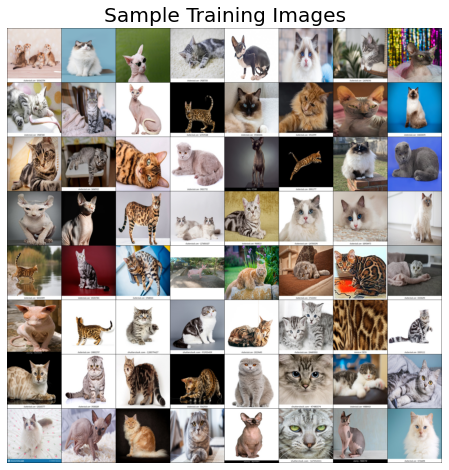

In [4]:
sample_batch = next(iter(trainloader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0))); # Verify that our image transformation works

What I just did was load in the data and transform it to fit our model requirements, i.e setting the correct image size for the input and transforming the raw image data to torch.Tensor. I also created DataLoaders which function as generators to allow quick and space-efficient inputting of training and testing data.

### Creating CNN from Scratch

In [5]:
class cat_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [6]:
# Create training function
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X)
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1) # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        model.eval()
        with torch.no_grad():  # stop pytorch doing computational graph stuff under-the-hood, saves memory and time
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [7]:
model = cat_classifier()
model.to(device)
model.eval()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, trainloader, validloader)

Epoch 1: Train Loss: 1.792. Valid Loss: 1.781. Valid Accuracy: 0.24.
Epoch 2: Train Loss: 1.758. Valid Loss: 1.736. Valid Accuracy: 0.28.
Epoch 3: Train Loss: 1.635. Valid Loss: 1.703. Valid Accuracy: 0.30.
Epoch 4: Train Loss: 1.503. Valid Loss: 1.629. Valid Accuracy: 0.34.
Epoch 5: Train Loss: 1.403. Valid Loss: 1.503. Valid Accuracy: 0.36.


Here I created the framework for a from-scratch CNN, then trained and scored it using the training and testing data. Since this is an image classifying problem, the main metric I will be looking at is accuracy. The valid accuracy for this model is not great, with the best score after five epochs of training being .36. I used the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer as the Adam algorithm is quicker than traditional stochastic gradient decent algorithms and has fewer hyperparameters that would require tuning.

### Building upon DenseNet

Here I will leverage the pre-trained model DenseNet and add a few layers on top of it. I suspect that this model will perform much better as it has been optimized for image classification and has been trained on the ImageNet dataset, which contains almost 1000x more images than our training set. I will not be updating the DenseNet layer parameters for this part as I am curious as to how much better the model performs without any layer tuning.

In [8]:
densenet = models.densenet121(pretrained=True) # load in pre-trained densenet

for param in densenet.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [9]:
new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,6)) # Change output to only give 6 possible classifications

densenet.classifier = new_layers

The three layers that I added here reduced the DenseNet output layer from a size of (1024,1) to (6,1) to better suit my needs of classifying six different cat breeds. Originally the DenseNet model was able to classify over 1000 different things which is why the original output size was so large.

In [10]:
densenet.to(device) # Set up for future CUDA processes
criterion = criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, epochs=20)

Epoch 1: Train Loss: 0.818. Valid Loss: 0.556. Valid Accuracy: 0.78.
Epoch 2: Train Loss: 0.305. Valid Loss: 0.287. Valid Accuracy: 0.91.
Epoch 3: Train Loss: 0.205. Valid Loss: 0.219. Valid Accuracy: 0.91.
Epoch 4: Train Loss: 0.152. Valid Loss: 0.200. Valid Accuracy: 0.92.
Epoch 5: Train Loss: 0.076. Valid Loss: 0.216. Valid Accuracy: 0.92.
Epoch 6: Train Loss: 0.088. Valid Loss: 0.287. Valid Accuracy: 0.89.
Epoch 7: Train Loss: 0.075. Valid Loss: 0.233. Valid Accuracy: 0.93.
Epoch 8: Train Loss: 0.067. Valid Loss: 0.234. Valid Accuracy: 0.90.
Epoch 9: Train Loss: 0.094. Valid Loss: 0.429. Valid Accuracy: 0.86.
Epoch 10: Train Loss: 0.088. Valid Loss: 0.242. Valid Accuracy: 0.93.
Epoch 11: Train Loss: 0.030. Valid Loss: 0.245. Valid Accuracy: 0.91.
Epoch 12: Train Loss: 0.025. Valid Loss: 0.227. Valid Accuracy: 0.91.
Epoch 13: Train Loss: 0.026. Valid Loss: 0.251. Valid Accuracy: 0.92.
Epoch 14: Train Loss: 0.024. Valid Loss: 0.237. Valid Accuracy: 0.92.
Epoch 15: Train Loss: 0.019. 

The model built upon densenet performed significantly better, with a final valid accuracy of .91 for 20 epochs of training. The from-scratch model achieved a .41 valid accuracy after 5 epochs while for 5 epochs the densenet received a .91 score. This is not surprising in any way as the DenseNet model had many more pre-trained weights and a larger neural net to work with compared to the from-scratch model.

### Layer Tuning

Here I will explore what happens to the valid accuracy when I begin to tune the layers of DenseNet. Tuning the layers just means that I will now be updating the weights were previously trained in the DenseNet using the ImageNet data set by providing the model with the cat breed training images. I'll try tuning all of the layers, then explore what happens if I only tune the last few layers.

In [11]:
# tuning all layers
densenet = models.densenet121(pretrained=True)

new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,6)) # Make output (6,1)

densenet.classifier = new_layers

densenet.to(device)
criterion = criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, epochs=20)

Epoch 1: Train Loss: 1.013. Valid Loss: 9.984. Valid Accuracy: 0.41.
Epoch 2: Train Loss: 0.587. Valid Loss: 1.708. Valid Accuracy: 0.61.
Epoch 3: Train Loss: 0.369. Valid Loss: 1.470. Valid Accuracy: 0.60.
Epoch 4: Train Loss: 0.344. Valid Loss: 1.107. Valid Accuracy: 0.68.
Epoch 5: Train Loss: 0.230. Valid Loss: 1.580. Valid Accuracy: 0.64.
Epoch 6: Train Loss: 0.211. Valid Loss: 1.174. Valid Accuracy: 0.68.
Epoch 7: Train Loss: 0.245. Valid Loss: 1.399. Valid Accuracy: 0.59.
Epoch 8: Train Loss: 0.143. Valid Loss: 1.957. Valid Accuracy: 0.57.
Epoch 9: Train Loss: 0.231. Valid Loss: 1.847. Valid Accuracy: 0.54.
Epoch 10: Train Loss: 0.171. Valid Loss: 1.939. Valid Accuracy: 0.56.
Epoch 11: Train Loss: 0.177. Valid Loss: 0.869. Valid Accuracy: 0.78.
Epoch 12: Train Loss: 0.155. Valid Loss: 1.032. Valid Accuracy: 0.76.
Epoch 13: Train Loss: 0.157. Valid Loss: 1.895. Valid Accuracy: 0.48.
Epoch 14: Train Loss: 0.135. Valid Loss: 0.731. Valid Accuracy: 0.76.
Epoch 15: Train Loss: 0.136. 

Interestingly enough, here you can see that when tuning all of the layers of DenseNet, the valid accuracy decreases. I suspect this is due to the model having already had some nodes/layers that worked well for animal classification now being updated incorrectly to attempt to correctly identify only animals. There is also some oscillating accuracy scoring that I suspect is the model getting "stuck" with the weight tuning and not being able to adequately find certain weights that consistently increase model accuracy.

In [12]:
# tuning last 2 layers
densenet = models.densenet121(pretrained=True)

for layer in densenet.features[:-2]:
    for param in layer.parameters():
        param.requires_grad = False

new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,6)) # Output now (6,1)

densenet.classifier = new_layers

densenet.to(device)
criterion = criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, epochs=20)

Epoch 1: Train Loss: 0.618. Valid Loss: 0.873. Valid Accuracy: 0.85.
Epoch 2: Train Loss: 0.127. Valid Loss: 0.300. Valid Accuracy: 0.91.
Epoch 3: Train Loss: 0.071. Valid Loss: 0.378. Valid Accuracy: 0.88.
Epoch 4: Train Loss: 0.053. Valid Loss: 0.331. Valid Accuracy: 0.91.
Epoch 5: Train Loss: 0.024. Valid Loss: 0.304. Valid Accuracy: 0.90.
Epoch 6: Train Loss: 0.051. Valid Loss: 0.402. Valid Accuracy: 0.91.
Epoch 7: Train Loss: 0.049. Valid Loss: 0.387. Valid Accuracy: 0.90.
Epoch 8: Train Loss: 0.031. Valid Loss: 0.483. Valid Accuracy: 0.89.
Epoch 9: Train Loss: 0.027. Valid Loss: 0.345. Valid Accuracy: 0.92.
Epoch 10: Train Loss: 0.021. Valid Loss: 0.301. Valid Accuracy: 0.93.
Epoch 11: Train Loss: 0.021. Valid Loss: 0.273. Valid Accuracy: 0.92.
Epoch 12: Train Loss: 0.009. Valid Loss: 0.238. Valid Accuracy: 0.92.
Epoch 13: Train Loss: 0.004. Valid Loss: 0.282. Valid Accuracy: 0.93.
Epoch 14: Train Loss: 0.006. Valid Loss: 0.188. Valid Accuracy: 0.95.
Epoch 15: Train Loss: 0.001. 

This is a much better result than before, where now you can see that the model is consistently classifying the images correctly around 95% of the time.

In [13]:
# tuning last 4 layers
densenet = models.densenet121(pretrained=True)

for layer in densenet.features[:-4]:
    for param in layer.parameters():
        param.requires_grad = False

new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,6))

densenet.classifier = new_layers

densenet.to(device)
criterion = criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, epochs=20)

Epoch 1: Train Loss: 0.671. Valid Loss: 4.736. Valid Accuracy: 0.58.
Epoch 2: Train Loss: 0.244. Valid Loss: 1.096. Valid Accuracy: 0.80.
Epoch 3: Train Loss: 0.208. Valid Loss: 0.993. Valid Accuracy: 0.79.
Epoch 4: Train Loss: 0.120. Valid Loss: 0.457. Valid Accuracy: 0.88.
Epoch 5: Train Loss: 0.087. Valid Loss: 0.333. Valid Accuracy: 0.91.
Epoch 6: Train Loss: 0.069. Valid Loss: 0.476. Valid Accuracy: 0.88.
Epoch 7: Train Loss: 0.080. Valid Loss: 0.456. Valid Accuracy: 0.88.
Epoch 8: Train Loss: 0.059. Valid Loss: 0.431. Valid Accuracy: 0.92.
Epoch 9: Train Loss: 0.029. Valid Loss: 0.453. Valid Accuracy: 0.91.
Epoch 10: Train Loss: 0.027. Valid Loss: 0.364. Valid Accuracy: 0.93.
Epoch 11: Train Loss: 0.063. Valid Loss: 0.662. Valid Accuracy: 0.87.
Epoch 12: Train Loss: 0.114. Valid Loss: 0.669. Valid Accuracy: 0.86.
Epoch 13: Train Loss: 0.095. Valid Loss: 0.706. Valid Accuracy: 0.84.
Epoch 14: Train Loss: 0.039. Valid Loss: 0.466. Valid Accuracy: 0.90.
Epoch 15: Train Loss: 0.015. 

This result is similar to the previous one where I only tuned the last two layers, but not quite as accurate. The apparent result from trying these layer tunings is: DenseNet is pretty incredible by itself, only a small amount of output correcting layers are required to really make the model shine. I am very impressed that a model with 1024 possible outputs correctly classified six different cat breeds around 90% of the time, while that same model with only six possible outputs correctly classified those same breeds 95% of the time.

### Summary and Results

I tried 3 tuning methods which all built upon the densenet classifier. The baseline comparison was the model with no tuned layers, which achieved an accuracy of .91 after training and validation. The model with full layer tuning only got to .72 validation score after 20 epochs, and took significantly longer to train than any other model. The next 2 models only had a few layers tuned, one with the last 2 and the other with the last 4. Both models were quicker to train than the full layer tuning model, and the one with the best valid accuracy was the last 2-layer tuned model. This model performed a small amount better than the baseline, but it is not better than the baseline in my opinion as it still look noticeably longer to train than the baseline. Compared to the from-scratch model, the 2-layer tuned model performed significantly better but still took a much longer time to train.